<a href="https://colab.research.google.com/github/MarcoSteuri/music_speech_classification/blob/main/NN_sound_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import modules and load functions

In [1]:
# Source functions und Transformationen zu tensorflow dataset: https://github.com/jkcas22/music_speech/blob/main/RNN.ipynb

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
#from tensorflow.keras import regularizers
from scipy.signal import hann
from scipy.io import wavfile
	
def get_mag_phs(re_im):
    mag_phs=[]
    for c in re_im:
        re=c[0]
        im=c[1]
        mag_phs.append([np.sqrt(re**2 + im**2), np.angle(re + im * 1j)])
    return np.array(mag_phs)


def get_logmag(re_im):
    logmag=[]
    for c in re_im:
        re=c[0]
        im=c[1]
        logmag.append(np.log(np.sqrt(re**2 + im**2)))
    return np.array(logmag)


def get_re_im(mag_phs):
    re_im=[]
    for c in mag_phs:
        mag=c[0]
        phs=c[1]
        re_im.append([mag * np.cos(phs), mag * np.sin(phs)])
    return np.array(re_im)


def load_wav(filenames):
    wl=[]
    for name in filenames:
        _, w = wavfile.read(name)
        w = w.astype(np.float32)
        norm = np.max(np.abs(w))
        w = w / norm
        w -= np.mean(w)
        wl.append(w)
    return np.array(wl)


def dft(sounds, fft_chunks, fft_step=256, fft_size=512):
    #fft_chunks = len(sounds[0]) // fft_step
    hann_win = hann(fft_size)
    re_im = []
    for signal in sounds:
        s = []
        for i in range(fft_chunks):
            frame = signal[(i * fft_step):(i * fft_step + fft_size)]
            frame = np.pad(frame, (0, fft_size - len(frame)), 'constant')
            frame *= hann_win
            s.append(frame)
        s = np.array(s)
        N = s.shape[-1]
        k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [1, N // 2])
        x = np.reshape(np.linspace(0.0, N - 1, N), [N, 1])
        freqs = np.dot(x, k)
        reals = np.dot(s, np.cos(freqs)) * (2.0 / N)
        imags = np.dot(s, np.sin(freqs)) * (2.0 / N)
        re_im.append([reals,imags])
    return np.array(re_im)


def dft_logmag(sounds, fft_chunks, fft_step=256, fft_size=512):
    re_im = dft(sounds, fft_chunks, fft_step, fft_size)
    return get_logmag(re_im)


def idft(re, im, step_size=256, fft_size=512):
	N = re.shape[1] * 2
	k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [N // 2, 1])
	x = np.reshape(np.linspace(0.0, N - 1, N), [1, N])
	freqs = np.dot(k, x)
	signal = np.zeros((re.shape[0] * step_size + fft_size,))
	recon = np.dot(re, np.cos(freqs)) + np.dot(im, np.sin(freqs))
	for hop_i, frame in enumerate(recon):
		signal[(hop_i * step_size): (hop_i * step_size + fft_size)] += frame
	return signal

# Load files

In [2]:
#mount google drive when on google colab and set working directory
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/CAS/M6/Music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')

Mounted at /content/drive

Working directory: /content/drive/MyDrive/CAS/M6/Music_speech


In [3]:
#Load music
music_dir = './data/music_wav'
if not os.path.isdir(music_dir): 
    print(f'copy folder "music_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')
#Keep files for final test
music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]
music_test = [os.path.join(music_dir, file) for file in music_test]

#List with path to all music files:
music = [os.path.join(music_dir, file_i) for file_i in os.listdir(music_dir) if file_i.endswith('.wav')]
music = list(set(music)-set(music_test))
print(f"Music files: {len(music)}, for final test: {len(music_test)}")

speech_dir = './data/speech_wav'
if not os.path.isdir(speech_dir): 
    print(f'copy folder "speech_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file_i) for file_i in os.listdir(speech_dir) if file_i.endswith('.wav')]
speech = list(set(speech)-set(speech_test))
		  
print(f"Speech files: {len(speech)}, for final test: {len(speech_test)}")


Music files: 52, for final test: 12
Speech files: 52, for final test: 12


# Assign labels and create tensorflow datasets

In [4]:
#Create numpy arrays with labels (0 for music, 1 for speech)
test = speech_test + music_test
test_labels = np.zeros(len(test))
test_labels[0:len(speech_test)]=1

split = len(speech)*8//10

train = speech[:split] + music[:split]
train_labels = np.zeros(len(train))
train_labels[:split]=1

validate = speech[split:] + music[split:]
validate_labels = np.zeros(len(validate))
validate_labels[:len(speech[split:])]=1



In [5]:
test_sounds = load_wav(test) #Sampled at a rate of 44100 Hz. Hz = Anzahl der Schwingungen pro Sekunde.
test_sounds.shape #30 * 44100 = 1323000 samples. Taking the magnitued of the array (only considering the positive frequencies) --> 1323000 / 2 --> 661500. True??
train_sounds = load_wav(train)
validate_sounds = load_wav(validate)

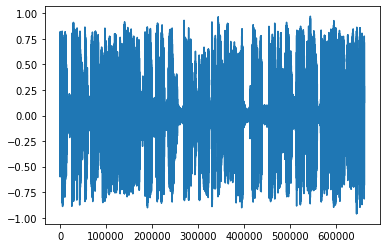

In [6]:
plt.plot(train_sounds[0])
plt.show()

In [7]:
fft_step=256
fft_size=512
fft_chunks = len(train_sounds[0])//fft_step

test_logmag = dft_logmag(test_sounds,fft_chunks,fft_step,fft_size)
train_logmag = dft_logmag(train_sounds,fft_chunks,fft_step,fft_size)
validate_logmag = dft_logmag(validate_sounds,fft_chunks,fft_step,fft_size)

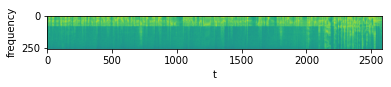

In [8]:
plt.imshow(train_logmag[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [9]:
patch_step = 32 #32
patch_size = 64 #64

def ds_window(sound, label, patch_step, patch_size):
    labels = np.ones(len(sound))*label
    sound = np.c_[sound,labels]
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    return ds

def ds_patches(sounds, labels, patch_step, patch_size):
    ds = ds_window(sounds[0],labels[0],patch_step,patch_size)
    for sound, label in zip(sounds[1:],labels[1:]): ds = ds.concatenate(ds_window(sound,label,patch_step,patch_size))
    ds = ds.map(lambda x: (x[:,:-1], x[0,-1]))
    return ds

test_ds = ds_patches(test_logmag, test_labels, patch_step, patch_size)
train_ds = ds_patches(train_logmag, train_labels, patch_step, patch_size)
validate_ds = ds_patches(validate_logmag, validate_labels, patch_step, patch_size)

n_test = test_logmag.shape[0]*(((test_logmag.shape[1]-patch_size)//patch_step)+1)
n_train = train_logmag.shape[0]*(((train_logmag.shape[1]-patch_size)//patch_step)+1)
n_validate = validate_logmag.shape[0]*(((validate_logmag.shape[1]-patch_size)//patch_step)+1)

print(f"{n_test} samples for test.")
print(f"{n_train} samples for training.")
print(f"{n_validate} samples for validation.")
print(f"type of test_ds: {type(test_ds)}")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


1896 samples for test.
6478 samples for training.
1738 samples for validation.
type of test_ds: <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [10]:
n = 10
for sound, label in train_ds.take(n):
    sound = sound.numpy()
    print(f"{sound.shape} : {sound[[0,patch_step],0]} : {sound[[-patch_step-1,-1],0]}")

(64, 256) : [-4.17556469 -4.42295177] : [-5.4016218  -3.93905954]
(64, 256) : [-4.42295177 -5.81069117] : [-3.93905954 -4.7799591 ]
(64, 256) : [-5.81069117 -4.45184693] : [-4.7799591  -4.43226119]
(64, 256) : [-4.45184693 -6.71494628] : [-4.43226119 -5.79015098]
(64, 256) : [-6.71494628 -4.82852724] : [-5.79015098 -5.88388674]
(64, 256) : [-4.82852724 -6.78243588] : [-5.88388674 -4.54727623]
(64, 256) : [-6.78243588 -5.00252049] : [-4.54727623 -4.80770076]
(64, 256) : [-5.00252049 -5.78203664] : [-4.80770076 -6.24158988]
(64, 256) : [-5.78203664 -6.61636024] : [-6.24158988 -6.11616346]
(64, 256) : [-6.61636024 -4.53429082] : [-6.11616346 -5.05203115]


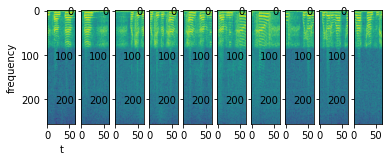

In [11]:
for i, (sound, label) in enumerate(train_ds.take(n)):
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy().T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()

In [12]:
sound

<tf.Tensor: shape=(64, 256), dtype=float64, numpy=
array([[ -6.61636024,  -5.0215097 ,  -4.84424573, ..., -12.39051193,
         -9.33309265,  -9.34167509],
       [ -5.91043656,  -5.12072323,  -6.31284775, ..., -10.38735587,
         -9.4255458 , -10.07297476],
       [ -8.74387697,  -5.45073493,  -5.58130558, ...,  -9.33763326,
         -9.18610732,  -8.87777939],
       ...,
       [ -4.48574276,  -3.54507   ,  -3.64023635, ...,  -9.45669171,
        -10.11085707,  -9.38627017],
       [ -5.42936544,  -3.93115517,  -4.23554167, ...,  -9.04574756,
         -9.29611685,  -9.84009217],
       [ -5.05203115,  -4.17718254,  -4.13593437, ..., -10.54983694,
        -10.7897159 , -10.33932016]])>

In [13]:
#Shuffle and batch datasets for use directly in model.fit
test_ds = test_ds.shuffle(n_test).batch(patch_size)
train_ds = train_ds.shuffle(n_train).batch(patch_size)
validate_ds = validate_ds.shuffle(n_validate).batch(patch_size)

In [14]:
#Test how enumerate works..
values = ["a", "b", "c"]
for count, value in enumerate(values):
  print(count, value)

0 a
1 b
2 c


# Create the models

##Model 1 - four convolutional layers, two fully connected

In [58]:
# Define the input shape of the images
input_shape = (64, 256, 1)

# Define the model architecture
model = tf.keras.Sequential([
    
    # First convolutional layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #tf.keras.layers.BatchNormalization(),
    
    # Second convolutional layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #tf.keras.layers.BatchNormalization(),
    
    # Third convolutional layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #tf.keras.layers.BatchNormalization(),
    
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #tf.keras.layers.BatchNormalization(),
    
    # Flatten the output of the convolutional layers
    tf.keras.layers.Flatten(),
    
    # First fully connected layer
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(rate=0.2), #Zuerst gut validation accuracy, dann schlechter und wieder besser (nope!)
    
    # Second fully connected layer
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Define optimizer
modelOptimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
# Compile the model
model.compile(optimizer=modelOptimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 62, 254, 32)       320       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 31, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 29, 125, 64)       18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 14, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 12, 60, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 6, 30, 128)     

In [40]:
save_path = '/content/drive/MyDrive/CAS/M6/Music_speech/models/model1/model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5'
save_callback = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

hist1 = model.fit(train_ds,
          epochs=50, batch_size=32, #epochs=5 
          validation_data=validate_ds, callbacks=save_callback)

Epoch 1/50
102/102 [==============================] - 9s 50ms/step - loss: 0.3271 - accuracy: 0.8645 - val_loss: 0.6520 - val_accuracy: 0.5000
Epoch 2/50
102/102 [==============================] - 6s 39ms/step - loss: 0.1842 - accuracy: 0.9328 - val_loss: 0.5279 - val_accuracy: 0.7894
Epoch 3/50
102/102 [==============================] - 6s 40ms/step - loss: 0.1378 - accuracy: 0.9525 - val_loss: 0.5164 - val_accuracy: 0.6968
Epoch 4/50
102/102 [==============================] - 6s 40ms/step - loss: 0.1140 - accuracy: 0.9631 - val_loss: 0.2854 - val_accuracy: 0.9108
Epoch 5/50
102/102 [==============================] - 6s 39ms/step - loss: 0.0994 - accuracy: 0.9696 - val_loss: 0.3264 - val_accuracy: 0.8642
Epoch 6/50
102/102 [==============================] - 6s 38ms/step - loss: 0.0909 - accuracy: 0.9710 - val_loss: 0.6479 - val_accuracy: 0.7526
Epoch 7/50
102/102 [==============================] - 6s 38ms/step - loss: 0.0829 - accuracy: 0.9750 - val_loss: 0.2941 - val_accuracy: 0.8832

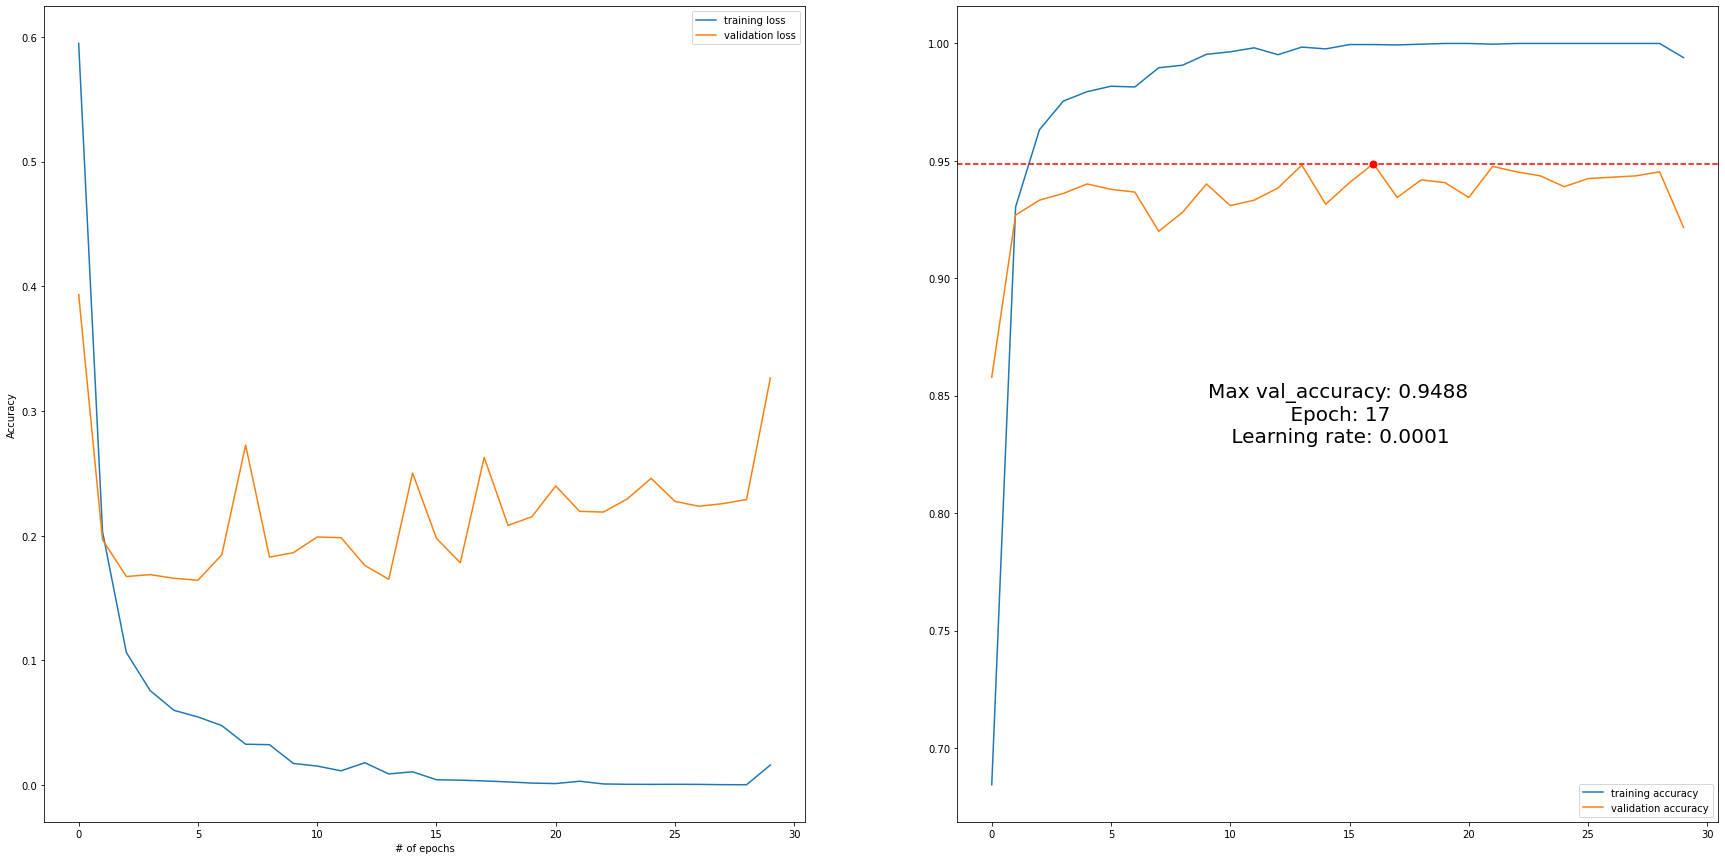

In [76]:
# Plot loss and accuracy for epochs
hist = hist2 #change to hist2 for model 2

max_val_accuracy = max(hist.history['val_accuracy'])
max_train_accuracy = max(hist.history['accuracy'])
epoch_max_val_accuracy = hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))+1

fig, axs = plt.subplots(1, 2, figsize=(30,15))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[0].set(xlabel = '# of epochs', ylabel = 'Loss')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])
axs[0].set(xlabel = '# of epochs', ylabel = 'Accuracy')

#plot the maximum accuracy as lines
axs[1].axhline(y=max_val_accuracy, color='r', linestyle='--')
#axs[1].axhline(y=max_train_accuracy, color='b', linestyle='--')

# Get the indices of the data points with max val accuracy and plot
indices = [i for i, j in enumerate(hist.history['val_accuracy']) if j == max_val_accuracy]
axs[1].plot([hist.epoch[i] for i in indices], [hist.history['val_accuracy'][i] for i in indices], 'o', color='r', markersize=7)

# Calculate the coordinates of the middle of the axs[1] as and plot accuracy as number
x_mid = (axs[1].get_xlim()[0] + axs[1].get_xlim()[1]) / 2
y_mid = (axs[1].get_ylim()[0] + axs[1].get_ylim()[1]) / 2
axs[1].text(x_mid, y_mid, f"Max val_accuracy: {max_val_accuracy:.4f}\n Epoch: {epoch_max_val_accuracy}\n Learning rate: {modelOptimizer.learning_rate.numpy():.4f}", fontsize=20, ha='center', va='center')

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')

plt.show()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

30/30 [==============================] - 1s 18ms/step - loss: 1.2266 - accuracy: 0.8133
Test loss: 1.2266314029693604
Test accuracy: 0.8132911324501038


##Second model

In [73]:
# Define the model architecture
model2 = tf.keras.models.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', input_shape=input_shape),
    # Second convolutional layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'),
    # Third convolutional layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu'),
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'),
    # Flatten the output of the convolutional layers
    tf.keras.layers.Flatten(),
    # First fully connected layer
    tf.keras.layers.Dense(units=512, activation='relu'),
    # Second fully connected layer (output layer)
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

#Define optimizer
modelOptimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# Compile the model
model2.compile(optimizer=modelOptimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 31, 127, 32)       320       
                                                                 
 conv2d_69 (Conv2D)          (None, 15, 63, 64)        18496     
                                                                 
 conv2d_70 (Conv2D)          (None, 7, 31, 128)        73856     
                                                                 
 conv2d_71 (Conv2D)          (None, 3, 15, 256)        295168    
                                                                 
 flatten_17 (Flatten)        (None, 11520)             0         
                                                                 
 dense_34 (Dense)            (None, 512)               5898752   
                                                                 
 dense_35 (Dense)            (None, 1)               

In [74]:
save_path = '/content/drive/MyDrive/CAS/M6/Music_speech/models/model2/model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5'
save_callback = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
hist2 = model2.fit(train_ds,
          epochs=30, batch_size=32, 
          validation_data=validate_ds,
          callbacks=save_callback)

Epoch 1/30
102/102 [==============================] - 7s 27ms/step - loss: 0.5948 - accuracy: 0.6843 - val_loss: 0.3934 - val_accuracy: 0.8579
Epoch 2/30
102/102 [==============================] - 5s 24ms/step - loss: 0.2032 - accuracy: 0.9304 - val_loss: 0.1968 - val_accuracy: 0.9269
Epoch 3/30
102/102 [==============================] - 4s 24ms/step - loss: 0.1063 - accuracy: 0.9633 - val_loss: 0.1673 - val_accuracy: 0.9333
Epoch 4/30
102/102 [==============================] - 6s 32ms/step - loss: 0.0757 - accuracy: 0.9755 - val_loss: 0.1688 - val_accuracy: 0.9361
Epoch 5/30
102/102 [==============================] - 5s 24ms/step - loss: 0.0600 - accuracy: 0.9795 - val_loss: 0.1659 - val_accuracy: 0.9402
Epoch 6/30
102/102 [==============================] - 4s 23ms/step - loss: 0.0547 - accuracy: 0.9818 - val_loss: 0.1643 - val_accuracy: 0.9379
Epoch 7/30
102/102 [==============================] - 5s 22ms/step - loss: 0.0477 - accuracy: 0.9815 - val_loss: 0.1847 - val_accuracy: 0.9367

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model2.evaluate(test_ds)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Test Models on final test set

In [30]:
# load the model from a specific epoch
from tensorflow.keras.models import load_model
model_loaded = load_model("/content/drive/MyDrive/CAS/M6/Music_speech/models/model1/KEEP_model_epoch_15_val_acc_0.99.h5") #keep path to best model so far: "/content/drive/MyDrive/CAS/M6/Music_speech/models/model1/KEEP_model_epoch_15_val_acc_0.99.h5"

In [ ]:
# Evaluate the loaded model on the final test set
loss, accuracy = model_loaded.evaluate(test_ds)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

30/30 [==============================] - 1s 13ms/step - loss: 0.0758 - accuracy: 0.9668
Test loss: 0.07583115994930267
Test accuracy: 0.9667721390724182


In [ ]:
sound

<tf.Tensor: shape=(64, 256), dtype=float64, numpy=
array([[ -4.95269644,  -5.1864795 ,  -5.95194791, ..., -11.11972872,
        -10.5256648 , -10.15827843],
       [ -5.97586974,  -7.43099939,  -6.61416113, ..., -11.31071964,
        -11.18806212, -11.98211774],
       [ -5.18162259,  -5.50890279,  -6.49965236, ...,  -9.73369797,
         -9.61609071,  -9.47053125],
       ...,
       [ -4.17639655,  -4.87372634,  -5.60166328, ..., -10.38924579,
        -10.33832079, -11.27360089],
       [ -4.11510602,  -4.85362228,  -5.68011377, ..., -10.40498894,
         -9.93575422, -10.23684823],
       [ -4.12709913,  -4.62839984,  -5.95487679, ..., -11.52469106,
        -11.18106607, -10.53796022]])>

In [ ]:
#Add channel dimension
sound = np.expand_dims(sound, axis=0)  # add batch dimension
sound = np.expand_dims(sound, axis=-1)  # add channel dimension

# Test sample prediction
test_sample_pred = model_loaded.predict(sound)


1/1 [==============================] - 0s 208ms/step


In [ ]:
test_sample_pred

array([[0.99756986]], dtype=float32)

In [ ]:
label

<tf.Tensor: shape=(), dtype=float64, numpy=1.0>

# Explorations

In [ ]:
test_x = test_ds.map(lambda x, y: x)

In [ ]:
type(test_x)

In [ ]:
type(test_ds)